In [1]:
import pandas as pd
import kagglehub
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Download latest version
path = kagglehub.dataset_download("HRAnalyticRepository/absenteeism-dataset")

# La variable 'path' es un directorio, necesitamos encontrar el archivo de datos dentro de él.
print(f"El dataset se descargó en el directorio: {path}")

# Listar los archivos en el directorio
try:
    archivos_en_directorio = os.listdir(path)
    print("Archivos encontrados en el directorio:")
    for archivo in archivos_en_directorio:
        print(archivo)

    # Intenta encontrar el archivo CSV principal (puedes necesitar ajustar el nombre)
    archivo_csv = None
    for archivo in archivos_en_directorio:
        if archivo.endswith(".csv"):
            archivo_csv = archivo
            break # Asumimos que hay solo un archivo CSV principal, si hay más, ajusta la lógica

    if archivo_csv:
        ruta_completa_archivo = os.path.join(path, archivo_csv)
        print(f"\nIntentando leer el archivo: {ruta_completa_archivo}")

        # Leer el archivo CSV
        df = pd.read_csv(ruta_completa_archivo)
        print("Dataset cargado exitosamente en un DataFrame de pandas.")

    else:
        print("\nNo se encontró ningún archivo CSV en el directorio descargado.")
        print("Por favor, examina los archivos listados arriba e identifica el archivo de datos correcto.")

except FileNotFoundError:
    print(f"Error: No se encontró el directorio: {path}")
except Exception as e:
    print(f"Ocurrió un error al intentar listar o leer el archivo: {e}")

El dataset se descargó en el directorio: /kaggle/input/absenteeism-dataset
Archivos encontrados en el directorio:
MFGEmployees4.csv

Intentando leer el archivo: /kaggle/input/absenteeism-dataset/MFGEmployees4.csv
Dataset cargado exitosamente en un DataFrame de pandas.


In [2]:
df

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
0,1,Gutierrez,Molly,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,36.577306,Stores
1,2,Hardwick,Stephen,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,30.165072,Stores
2,3,Delgado,Chester,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,83.807798,Stores
3,4,Simon,Irene,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,70.020165,Stores
4,5,Delvalle,Edward,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,0.000000,Stores
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8331,8332,Coniglio,Bianca,F,Langley,Cashier,Customer Service,Langley,Stores,46.057544,4.838288,93.665111,Stores
8332,8333,Cox,Jimmie,M,Montney,Cashier,Customer Service,Fort St John,Stores,34.455490,2.427274,0.000000,Stores
8333,8334,Hawkins,Mary,F,West Vancouver,Cashier,Customer Service,West Vancouver,Stores,58.347160,4.009393,176.356940,Stores
8334,8335,Proctor,Theresa,F,Vancouver,Dairy Person,Dairy,Vancouver,Stores,43.340616,6.154837,60.321917,Stores


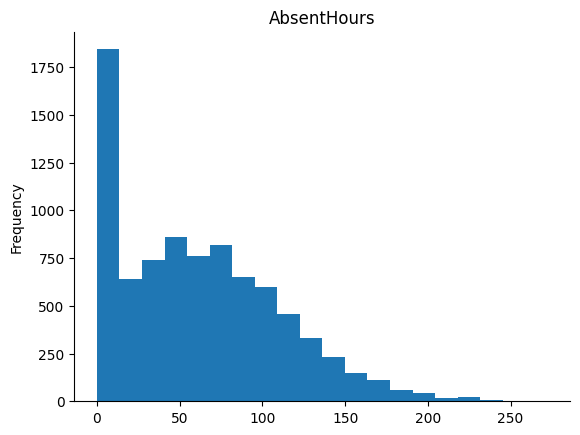

In [3]:
from matplotlib import pyplot as plt
df['AbsentHours'].plot(kind='hist', bins=20, title='AbsentHours')
plt.gca().spines[['top', 'right',]].set_visible(False)

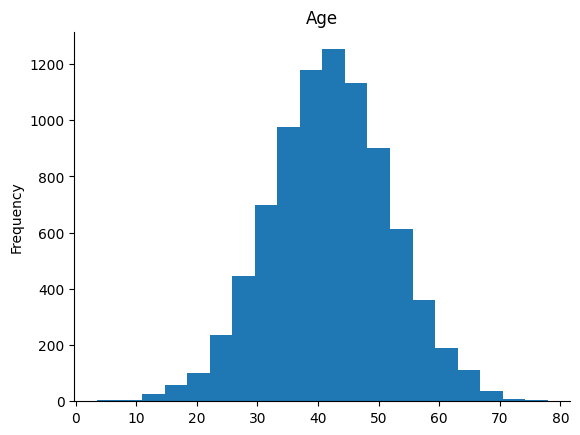

In [4]:
from matplotlib import pyplot as plt
df['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

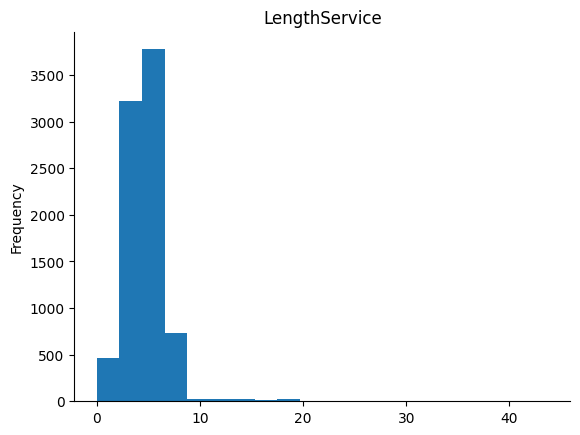

In [5]:
from matplotlib import pyplot as plt
df['LengthService'].plot(kind='hist', bins=20, title='LengthService')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
# Eliminar columnas no útiles
df_model = df.drop(columns=['EmployeeNumber', 'Surname', 'GivenName', 'AbsentHours'])

df_model

,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,BusinessUnit
0,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,Stores
1,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,Stores
2,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,Stores
3,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,Stores
4,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,Stores
...,...,...,...,...,...,...,...,...,...
8331,F,Langley,Cashier,Customer Service,Langley,Stores,46.057544,4.838288,Stores
8332,M,Montney,Cashier,Customer Service,Fort St John,Stores,34.455490,2.427274,Stores
8333,F,West Vancouver,Cashier,Customer Service,West Vancouver,Stores,58.347160,4.009393,Stores
8334,F,Vancouver,Dairy Person,Dairy,Vancouver,Stores,43.340616,6.154837,Stores


In [7]:
# Crear la variable binaria de ausentismo
df_model['HighAbsenteeism'] = df['AbsentHours'].apply(lambda x: 1 if x > 40 else 0)

# Codificar variables categóricas
df_encoded = pd.get_dummies(df_model, drop_first=True)

# Variables predictoras y objetivo
X = df_encoded.drop(columns='HighAbsenteeism')
y = df_encoded['HighAbsenteeism']

df_model

,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,BusinessUnit,HighAbsenteeism
0,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,Stores,0
1,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,Stores,0
2,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,Stores,1
3,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,Stores,1
4,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,Stores,0
...,...,...,...,...,...,...,...,...,...,...
8331,F,Langley,Cashier,Customer Service,Langley,Stores,46.057544,4.838288,Stores,1
8332,M,Montney,Cashier,Customer Service,Fort St John,Stores,34.455490,2.427274,Stores,0
8333,F,West Vancouver,Cashier,Customer Service,West Vancouver,Stores,58.347160,4.009393,Stores,1
8334,F,Vancouver,Dairy Person,Dairy,Vancouver,Stores,43.340616,6.154837,Stores,1


In [8]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calcular pesos para manejar desbalance
classes = [0, 1]
# Convertir la lista de clases a un array de NumPy
classes_np = np.array(classes)
weights = compute_class_weight(class_weight='balanced', classes=classes_np, y=y_train)
class_weights = {cls: weight for cls, weight in zip(classes, weights)}

# Random Forest con búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, class_weight=class_weights)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='f1', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: np.float64(1.2892498066511988),
                                                            1: np.float64(0.8167564919157276)},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=1)

In [9]:
# Mejor modelo
best_model = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntaje F1:", grid_search.best_score_)

Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Mejor puntaje F1: 0.8745507446169011


In [10]:
# Vizualizacion y evaluación
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[472 122]
 [178 896]]
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       594
           1       0.88      0.83      0.86      1074

    accuracy                           0.82      1668
   macro avg       0.80      0.81      0.81      1668
weighted avg       0.83      0.82      0.82      1668



<ipython-input-11-47f3ecae8b79>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance.head(20), palette='viridis')


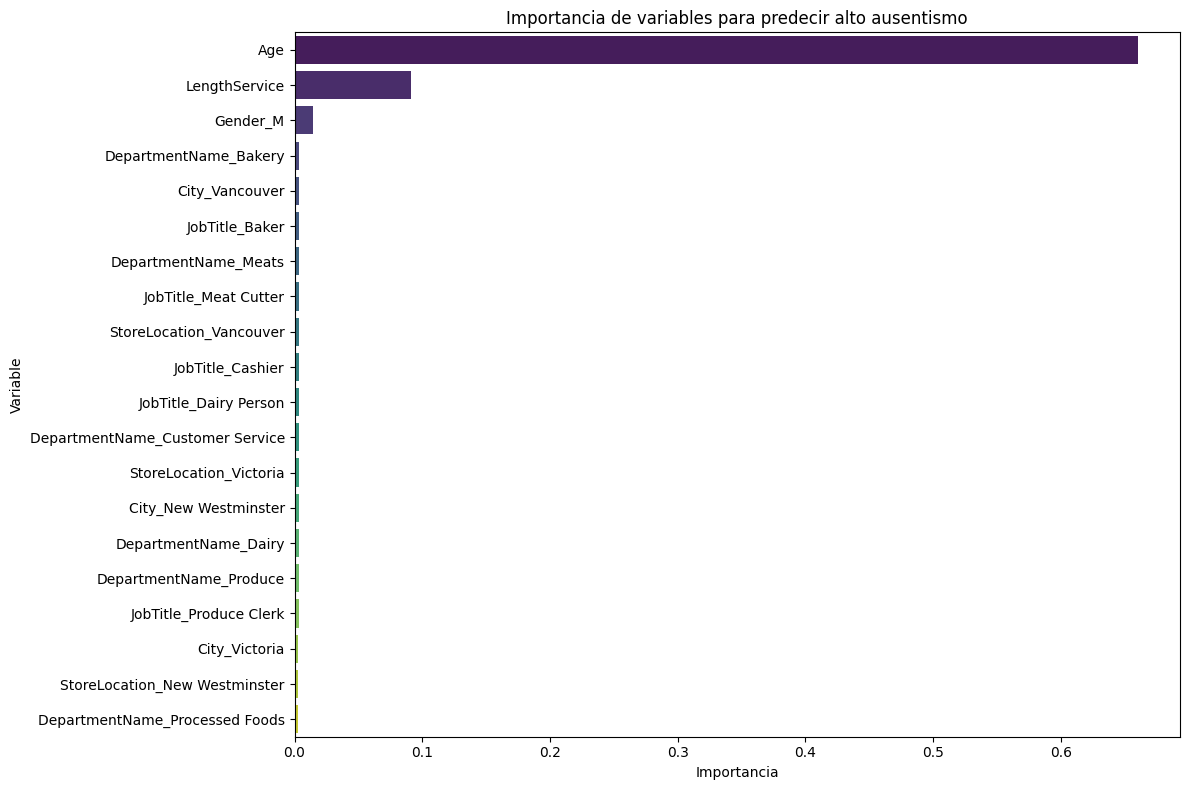

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extraer la importancia de las variables
importances = best_model.feature_importances_
features = X.columns

# Crear un DataFrame ordenado
feat_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

# Graficar las 20 variables más importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importance.head(20), palette='viridis')
plt.title('Importancia de variables para predecir alto ausentismo')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


In [12]:
# Añadir predicción al dataset original
df_resultado = df.copy()
df_resultado['Prediccion_AltoAusentismo'] = best_model.predict(X)

# Exportar dataset completo con predicción
df_resultado.to_csv("dataset_con_prediccion.csv", index=False)


In [13]:
from sklearn.tree import export_graphviz
from graphviz import Source

# Exportar árbol como imagen (sólo si usaste DecisionTreeClassifier)
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X, y)

from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = export_graphviz(tree, out_file=None,
                           feature_names=X.columns,
                           class_names=["Bajo", "Alto"],
                           filled=True, rounded=True,
                           special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("arbol_decision.png")


True

In [14]:
from sklearn.tree import export_text

rules = export_text(tree, feature_names=list(X.columns))
with open("reglas_arbol.txt", "w") as f:
    f.write(rules)


In [15]:
feat_importance.to_csv("importancia_variables_ausentismo.csv", index=False)
